<img src="../../../docs/images/DSPy8.png" alt="DSPy7 Image" height="150"/>

# Using __<ins>M</ins>ulti-stage <ins>I</ins>nstruction <ins>P</ins>roposal & <ins>O</ins>ptimization (MIPRO)__ in DSPy

### FAQ 🙋
#### 1) How does MIPRO work?
At a high level, the MIPRO program optimizer works by first __proposing__ candidate fewshot example sets and instructions for each prompt in your program, and then __optimizing__ over these fewshot example sets and instructions as hyperparameters for a specified number of trials. Each trial, the optimizer evaluates different combinations of prompts on a train set, which allows it to learn which combinations yield the best performance.

#### 2) How much will MIPRO cost me to run?
Note that __this notebook__ is free to run, because all LM calls have been cached. However, when using an optimizer on your own program, here is a breakdown of the upper bound of the number of calls to the task model and prompt model respectively:

- **Task model calls**: MIPRO makes up to __O(TxPxM)__ task model calls, where T is the number of trials, P is the number of prompts in the program, and M is the size of the train set. This is because the model is evaluating the program on the train set each trial. In practice, this should be lower given that MIPRO tunes poor trials early (ie. it may stop a trial after running on the first 100 or so examples if performance is poor).

- **Prompt model calls**: MIPRO makes up to N*P+10 prompt model calls, where N is the number of instruction / fewshot example set candidates to generate for each prompt, and P is the number of prompts in the program. The extra 10 calls comes from generating a summary of the data in the training set, which we use in the meta prompt to create better instructions.

#### 3) How should I configure the hyperparameters?
We have yet to run full hyperparameter sweeps with MIPRO, but based off of initial experimintation, we'd recommend the following:
- __Trial num__: Gains can be seen after about 20-30 trials. However, 100-200 trials can help with adding on additional marginal gains.
- __n__: This hyperparameter controls the number of candidate prompts and fewshot example sets that are generated to optimize over. With more trials and less prompts to optimize, we can set n to be higher, as we have more trials to explore different combinations of prompts. If your program has between 2-3 modules and is the `num_trials=30`, we'd recommend ~`n=10`. If n is higher (say `n=100`), then we can go higher to ~`n=15`. If you have a program with only 1 module and are keeping the program 0-shot (ie. no fewshot examples), then `num_trials` should be set to equal `n`, because each trial can explore a new instruction.
- __Training set size__: Between 200 and 500 training examples are recommended. Increasing the training set size can help prevent overfitting, but adds to the expense to run.

#### 4) What should I do if I want to reduce the cost?
You can always update hyperparameters accordingly, such as using a smaller train set, using less trials, or using a program with less modules.
Alternatively, one strategy would be to optimize using a cheaper task model (ie. locally hosted Llama-2), as initial experiments have shown that prompts optimized for a smaller model also transfer to working well on a larger model.


### 0] Setup

First, we will install __DSPy__ if it's not there already.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import regex as re

try: # When on google Colab, let's clone the notebook so we download the cache.
    import google.colab
    repo_path = 'dspy'

    !git -C $repo_path pull origin || git clone https://github.com/stanfordnlp/dspy $repo_path
except:
    repo_path = '.'

if repo_path not in sys.path:
    sys.path.append(repo_path)


import pkg_resources # Install the package if it's not installed
if not "dspy-ai" in {pkg.key for pkg in pkg_resources.working_set}:
    !pip install -U pip
    !pip install dspy-ai
    !pip install openai~=0.28.1
    !pip install -e $repo_path
    !pip install --upgrade cloudpickle==3.0.0

import dspy

Then, we'll __load in the cached requests__ for this tasks, so that we don't actually need to call any LMs for this notebook. We'll also load in our pre optimized program from hugging face to inspect later.

In [2]:
from huggingface_hub import hf_hub_download
import zipfile
import os

repo_id = 'kopsahlong/DSPy_MIPRO_notebook_cache'
cache_file_path = hf_hub_download(repo_id=repo_id, filename='MIPRO_notebook_cache.zip')
compiled_program_file_path = hf_hub_download(repo_id=repo_id, filename='compiled_program.pickle')
with zipfile.ZipFile(cache_file_path, 'r') as zip_ref:
    zip_ref.extractall(".")
os.environ["DSP_NOTEBOOK_CACHEDIR"] = f"{os.getcwd()}/MIPRO_notebook_cache"

We will also specify the __prompt LM model__ (in this case GPT 3.5), the __task LM model__ (Llama 13B) and the retrieval model we'll be using for our task (a HotPotQA multihop retrieval task).

In [3]:
### NOTE: if you'd like to run this code without a cache, you can remove these lines to configure your OPEN AI key ###
# import openai
# os.environ['OPENAI_API_KEY'] = "TODO: ADD YOUR OPEN AI KEY HERE"
# openai.api_key = os.environ.get('OPENAI_API_KEY')
# openai.api_base = "https://api.openai.com/v1"

prompt_model_name = "gpt-3.5-turbo-1106"
task_model_name = "meta-llama/Llama-2-13b-chat-hf"
colbert_v2_endpoint = "http://20.102.90.50:2017/wiki17_abstracts"

prompt_model = dspy.OpenAI(model=prompt_model_name, max_tokens=150)
task_model = dspy.HFClientTGI(model=task_model_name, port=[7140, 7141, 7142, 7143], max_tokens=150)

colbertv2 = dspy.ColBERTv2(url=colbert_v2_endpoint)

dspy.settings.configure(rm=colbertv2, lm=task_model)

### 1] Define Task

Here, we'll define the program that we'd like to run, which is a multihop [...] (we can say that it was loosely inspired by a certain paper). We additionally load in the data, and define how we'd like to evaluate this task.

In [4]:
import re
from dspy.evaluate import Evaluate
from dspy.datasets import HotPotQA
from dsp.utils import EM

class ReturnRankedDocuments(dspy.Signature):
    """Given a question we are trying to answer and a list of passages, return a comma separated list of the numbers associated with each passage. These numbers should be ordered by helpfulness in answering the question, with most helpful passage number first, and the least helpful last."""
    question = dspy.InputField(desc="The question we're trying to answer.")
    context = dspy.InputField(desc="List of potentially related passages.")
    ranking = dspy.OutputField(desc="A comma separated list of numbers corresponding to passage indices, ranked in descending order by their helpfulness in answering our question.")

class RankingMultiHop(dspy.Module):
    def __init__(self, hops, num_passages_to_retrieve, max_passages_in_context):
        super().__init__()
        self.hops = hops
        self.num_passages_to_retrieve = num_passages_to_retrieve
        self.max_passages_in_context = max_passages_in_context
        self.retrieve = dspy.Retrieve(k = self.num_passages_to_retrieve)
        self.generate_query = dspy.ChainOfThought("context ,question->search_query")
        self.generate_answer = dspy.ChainOfThought("context ,question->answer")
        self.generate_ranking = dspy.ChainOfThought(ReturnRankedDocuments)

    def forward(self,question):
        context = []
        full_context = []
        top_context = []
        max_passage_num = self.max_passages_in_context
        for hop in range(self.hops):
            # Get a new query
            query = self.generate_query(context = context, question = question).search_query
            # Get new passages
            context = self.retrieve(query).passages
            # Add these new passages to the previous top context
            full_context = top_context + context
            # Get the most important indices, ranked
            most_important_indices =  self.generate_ranking(question=question, context=full_context).ranking
            indices = [int(num) for num in re.findall(r'\d+', most_important_indices)]

            if len(indices) < max_passage_num:
                indices = range(1,max_passage_num+1)

            valid_indices = [index-1 for index in indices if index-1 < len(context)]
            top_indices = sorted(valid_indices, key=lambda x: x)[:max_passage_num+1]
            most_important_context_list = [context[idx] for idx in top_indices]
            # Save the top context
            top_context = most_important_context_list

        return dspy.Prediction(context=context, answer=self.generate_answer(context = top_context , question = question).answer)

program = RankingMultiHop(hops=4, num_passages_to_retrieve=5, max_passages_in_context=5)

# Load and configure the datasets.
TRAIN_SIZE = 500
EVAL_SIZE = 500

hotpot_dataset = HotPotQA(train_seed=1, eval_seed=2023, test_size=0)
trainset = [x.with_inputs('question') for x in hotpot_dataset.train][:TRAIN_SIZE]
devset = [x.with_inputs('question') for x in hotpot_dataset.dev][:EVAL_SIZE]

# Set up metrics
NUM_THREADS = 10

metric = dspy.evaluate.answer_exact_match

kwargs = dict(num_threads=NUM_THREADS, display_progress=True)
evaluate = Evaluate(devset=devset, metric=metric, **kwargs)

/lfs/0/kristaoo/miniconda3/envs/dspy_test/lib/python3.10/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


### 2] Baseline Evaluation
Now, we'll quickly evaluate our baseline program so that we can see how the performance using the Prompt Optimizer compares. We should see performance of about __21.6%__ on our trainset, and __22.6%__ on our devset.

In [5]:
baseline_train_score = evaluate(program,devset=trainset)
baseline_eval_score = evaluate(program, devset=devset)

Average Metric: 0 / 2  (0.0):   0%|          | 1/500 [00:00<03:17,  2.52it/s]

Average Metric: 80 / 500  (16.0): 100%|██████████| 500/500 [00:33<00:00, 15.10it/s]
/lfs/0/kristaoo/dspy/dspy/evaluate/evaluate.py:187: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(truncate_cell)


Average Metric: 80 / 500  (16.0%)


Average Metric: 107 / 500  (21.4): 100%|██████████| 500/500 [00:32<00:00, 15.31it/s]

Average Metric: 107 / 500  (21.4%)


### 3] Optimizing with MIPRO

Now let's get into the key method in this notebook - optimizing our program with MIPRO!

#### 3a] Compile Program
First, we'll get our optimized program. By default, we set `LOAD_PRECOMPILED_PROGRAM` to `True`, so that you can quickly access a program we've precompiled for you. However, if you wish to optimize yourself, `LOAD_PRECOMPILED_PROGRAM` can be set to `False` (though please note that this will require adding in your own LM API keys in the __Setup__ section above).

MIPRO only needs a metric, DSPy module, and training set to see huge gains on your task!  You can instantiate a MIPRO Optimizer and compile in just two lines:
```python
teleprompter = BayesianSignatureOptimizer(prompt_model=prompt_model, task_model=task_model, metric=metric, num_candidates=N, init_temperature=temperature)
compiled_program = teleprompter.compile(program, trainset=trainset, num_trials=trials, max_bootstrapped_demos=1,max_labeled_demos=2, eval_kwargs=eval_kwargs)
```

In [6]:
import cloudpickle as pickle
from dspy.teleprompt import MIPRO

LOAD_PRECOMPILED_PROGRAM = True

# By default, we will load the precompiled program
if LOAD_PRECOMPILED_PROGRAM:
    # Load a our precompiled program
    with open(compiled_program_file_path, 'rb') as file:
        # Load the data from the file
        compiled_program = pickle.load(file)
# Otherwise, if desired, the program can be compiled from scratch
else:
    # Define hyperparameters:
    N = 10 # The number of instructions and fewshot examples that we will generate and optimize over
    trials = 30 # The number of optimization trials to be run (we will test out a new combination of instructions and fewshot examples in each trial)
    temperature = 1.0 # The temperature configured for generating new instructions

    # Compile
    eval_kwargs = dict(num_threads=16, display_progress=True, display_table=0)
    teleprompter = MIPRO(prompt_model=prompt_model, task_model=task_model, metric=metric, num_candidates=N, init_temperature=temperature, verbose=True)
    compiled_program = teleprompter.compile(program, trainset=trainset, num_trials=trials, max_bootstrapped_demos=1,max_labeled_demos=2, eval_kwargs=eval_kwargs)

/lfs/0/kristaoo/dspy/examples/qa/hotpot/MIPRO_notebook_cache/compiler


#### 3b] Evaluate optimized program
Now, we evaluate our program that has been optimized with MIPRO. We see that performance on train and dev have improved by __+20pt__ and __+17.8pt__ respectively!

In [7]:
bayesian_train_score = evaluate(compiled_program, devset=trainset)
bayesian_eval_score = evaluate(compiled_program, devset=devset)

Average Metric: 192 / 500  (38.4): 100%|██████████| 500/500 [00:30<00:00, 16.24it/s]


Average Metric: 192 / 500  (38.4%)


Average Metric: 193 / 500  (38.6): 100%|██████████| 500/500 [00:32<00:00, 15.53it/s]


Average Metric: 193 / 500  (38.6%)


#### 3c] Visualizing scores & prompts over trials

Now, let's take a look at how this optimization looked over the course of each trial. We see that, in general, __performance increases overtime__, until it saturates after ~trial #13. Note that some of the 'pruned' trials have high scores, but were pruned early because they had comparitively lower scores on the easier slices of the data.

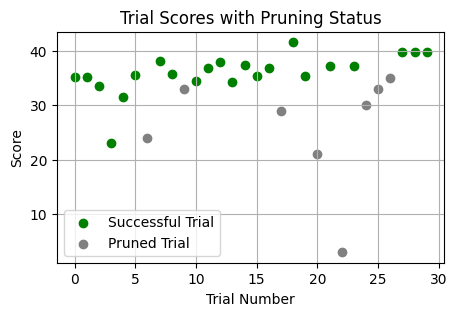

In [8]:
import matplotlib.pyplot as plt

trial_logs = compiled_program.trial_logs

# Extracting trial numbers, scores, and pruning status
trial_numbers = list(trial_logs.keys())
scores = [trial_logs[trial]['score'] for trial in trial_numbers]
pruning_status = [trial_logs[trial]['pruned'] for trial in trial_numbers]

# Plot setup
plt.figure(figsize=(5, 3))

# Plotting each point
for trial_number, score, pruned in zip(trial_numbers, scores, pruning_status):
    if pruned:
        plt.scatter(trial_number, score, color='grey', label='Pruned Trial' if 'Pruned Trial' not in plt.gca().get_legend_handles_labels()[1] else "")
    else:
        plt.scatter(trial_number, score, color='green', label='Successful Trial' if 'Successful Trial' not in plt.gca().get_legend_handles_labels()[1] else "")

plt.xlabel('Trial Number')
plt.ylabel('Score')
plt.title('Trial Scores with Pruning Status')
plt.grid(True)
plt.legend()
plt.show()

We can also __visualize the best prompts__ discovered by MIPRO as our trials progress... (though note that score increases are also due to the selected fewshot examples, which are not shown here for conciseness).

In [9]:
best_score = 0

def get_signature(predictor):
    if (hasattr(predictor, 'extended_signature')):
        return predictor.extended_signature
    elif (hasattr(predictor, 'signature')):
        return predictor.signature

print(f"Basline program | Score: {best_score}:")
for i,predictor in enumerate(program.predictors()):
    print(f"Prompt {i+1} Instruction: {get_signature(predictor).instructions}")
print()

print("----------------")

for trial_num in compiled_program.trial_logs:
    program_score = compiled_program.trial_logs[trial_num]["score"]
    program_pruned = compiled_program.trial_logs[trial_num]["pruned"]
    if program_score > best_score and not program_pruned:
        best_score = program_score
        best_program_so_far = compiled_program.trial_logs[trial_num]["program"]
    if trial_num % 5 == 0:
        print(f"Best program after {trial_num} trials | Score: {best_score}:")
        for i,predictor in enumerate(best_program_so_far.predictors()):
            print(f"Prompt {i+1} Instruction: {get_signature(predictor).instructions}")
        print()

Basline program | Score: 0:
Prompt 1 Instruction: Given the fields `context`, `question`, produce the fields `search_query`.
Prompt 2 Instruction: Given the fields `context`, `question`, produce the fields `answer`.
Prompt 3 Instruction: Given a question we are trying to answer and a list of passages, return a comma separated list of the numbers associated with each passage. These numbers should be ordered by helpfulness in answering the question, with most helpful passage number first, and the least helpful last.

----------------
Best program after 0 trials | Score: 35.2:
Prompt 1 Instruction: Given the fields `context` and `question`, identify the specific information being asked for and produce a concise and accurate response.
Prompt 2 Instruction: Given a fact-based question related to pop culture, history, or entertainment, identify specific works or individuals and provide a concise answer directly corresponding to the question posed.
Prompt 3 Instruction: Given a fact-based que